In [1]:
import pandas as pd
import numpy as np

# 전처리 완료 데이터 불러오기
data_a = pd.read_csv("./datasets/data_after/전처리_최종_V3_loglag.csv", encoding="CP949")
data_a = data_a.set_index('기준월')

# Min - Max Scaler
from sklearn.preprocessing import MinMaxScaler

data_c = data_a.copy().reset_index()
scaler = MinMaxScaler()
mm_temp = data_c.drop(columns=['기준월','만기전상환율'])
colnames = data_c.columns.drop(['기준월','만기전상환율'])

mm_data = scaler.fit_transform(mm_temp)

mm_result = pd.DataFrame(mm_data, columns=colnames)


# 최적의 알파값을 찾기 전에 피처랑 타겟 설정
## 주요 요인 별로 나눈 이유 -> 각 상관관계가 너무 높아서
    #### !!추가할 변수들 더 생기면 여기에 추가하기!!
    
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score

target = data_a['만기전상환율'] ### 타깃

feature_data = mm_result        ### ALL

## 변수 각각 분석
# feature_data_A = mm_result[['가중평균발행금리', '예금은행 대출금리', 'CD금리']]         ### 금리 요인(CD포함)
feature_data_A = mm_result[['가중평균발행금리', '예금은행 대출금리', '미국 실효금리']] ### 금리 요인(CD미포함)
feature_data_B = mm_result[['주택종합 매매가격지수', '평균 LTV', '평균 DTI']]           ### 부동산 요인
feature_data_C = mm_result[['15-64 실업자 수', '인플레이션율', '코스피 월별 종가']]     ### 거시경제 요인
##---------------------------------------------------------------------------------------------

## 변수 합쳐서 분석
feature_data2_A = mm_result[['가중평균발행금리', '예금은행 대출금리', '미국 실효금리']]                                 ### 금리 요인(CD미포함)
feature_data2_B = mm_result[['가중평균발행금리', '예금은행 대출금리', '미국 실효금리', '주택종합 매매가격지수', '평균 LTV', '평균 DTI']] ### 금리 요인 + 부동산 요인
feature_data2_C = mm_result[['가중평균발행금리', '예금은행 대출금리', '미국 실효금리', '주택종합 매매가격지수', '평균 LTV', '평균 DTI'
                            , '15-64 실업자 수', '인플레이션율', '코스피 월별 종가']]                                   ### 금리 요인 + 부동산 요인 + 거시경제 요인
##---------------------------------------------------------------------------------------------

## 변수 상관관계 높은거 vs 아닌거
feature_data_S = mm_result[['예금은행 대출금리', '미국 실효금리', '평균 LTV', '평균 DTI']]           ### 알파값 높여도 살아남은 요인
feature_data_W = mm_result[['가중평균발행금리', '주택종합 매매가격지수', '15-64 실업자 수', '인플레이션율', '코스피 월별 종가']]     ### 죽은 요인


In [ ]:

# VIF after Min-Max Scaling
## 카테고리끼리 VIF 비교

from test_package import find_vif

datas = [feature_data
        , feature_data_A, feature_data_B, feature_data_C
        , feature_data2_A, feature_data2_B, feature_data2_C
        , feature_data_S, feature_data_W]
num = range(1,len(datas)+1)

### >> for문에 들어가는 변수의 위치(feature_data는 0)도 VIF출력할 때 번호 붙여서 같이 출력(근데 번호는 1부터 시작하고 싶음)
### 요인들 번호 매기고 VIF 출력
for num, data in zip(num, datas):
        # print("번호", num)
        print(f'번호 {num}')
        find_vif(data)
        print(' ')

# 각 변수 요인들 끼리만
## GridSearchCV 수행하는 함수를 담은 패키지 로드
from test_package import find_best_alpha

## 75% 수준의 데이터만 가지고 돌렸을 때
datas = [feature_data
        , feature_data_A, feature_data_B, feature_data_C
        , feature_data2_A, feature_data2_B, feature_data2_C, feature_data_S, feature_data_W]
types = ['ridge', 'lasso', 'elastic']
# num = range(1,len(datas)+1)

### >> 모델 하나의 알파값을 구하는데 포문으로 모든 요인변수 돌리고나서 다 끝나면 다른 모델 넣어서 반복
### 모든 변수를 모델에 대입했을 때 최적의 앒파값 구하기
for i in types:
    print(" ")
    print(i)

    for p in datas:
        find_best_alpha(i, p[:161], target[:161])


### 여기에 요인변수랑 모델이랑 이 함수에 넣고 돌렸을 때 나오는 최적의 알파값을
### 이 다음 코드에 변수와 모델에 맞게 대입해서 최적의 RMSE를 한번에 구하고 싶음

from test_package import score_checker


find_best_alpha('elastic', feature_data_best[:161], target[:161])
score_checker('elastic', feature_data_best[:161], target[:161], 0.01)

### 요인 별 RMSE 스코어 계산

In [26]:
# 각 변수 요인들 끼리 RMSE 스코어 계산
import test_package as tp
# Hand-made Function
# type = 'lasso', 'ridge', 'elastic'

# feature_data_A.columns.to_list()
## 전체 변수 요인 별 RMSE 스코어 계산

def score_checker(model, data_set, ridge_alpha, lasso_alpha, elastic_alpha):
        print(f'{feature_data.columns.to_list()}')
        tp.score_checker(model, data_set[:161], target[:161], ridge_alpha)
        tp.score_checker(model, data_set[:161], target[:161], lasso_alpha)
        tp.score_checker(model, data_set[:161], target[:161], elastic_alpha)

print(f'전체 변수 요인 : {feature_data.columns.to_list()}')
tp.score_checker('ridge', feature_data[:161], target[:161], 1.0)
tp.score_checker('lasso', feature_data[:161], target[:161], 0.01)
tp.score_checker('elastic', feature_data[:161], target[:161], 0.01)
###------------------------------------------------------------------------------------------

## 개별 변수 요인 별 RMSE 스코어 계산
print(f'금리 요인 : {feature_data_A.columns.to_list()}')
tp.score_checker('ridge', feature_data_A[:161], target[:161], 1.0)
tp.score_checker('lasso', feature_data_A[:161], target[:161], 0.02)
tp.score_checker('elastic', feature_data_A[:161], target[:161], 0.01)

print(f'부동산 요인 : {feature_data_B.columns.to_list()}')
tp.score_checker('ridge', feature_data_B[:161], target[:161], 1.0)
tp.score_checker('lasso', feature_data_B[:161], target[:161], 0.04)
tp.score_checker('elastic', feature_data_B[:161], target[:161], 0.02)

print(f'거시경제 요인 : : {feature_data_C.columns.to_list()}')
tp.score_checker('ridge', feature_data_C[:161], target[:161], 0.24)
tp.score_checker('lasso', feature_data_C[:161], target[:161], 0.01)
tp.score_checker('elastic', feature_data_C[:161], target[:161], 0.01)
###------------------------------------------------------------------------------------------

## 변수 합한 요인 별 RMSE 스코어 계산
print(f'금리 요인 : {feature_data2_A.columns.to_list()}')
tp.score_checker('ridge', feature_data2_A[:161], target[:161], 1.0)
tp.score_checker('lasso', feature_data2_A[:161], target[:161], 0.02)
tp.score_checker('elastic', feature_data2_A[:161], target[:161], 0.01)

print(f'금리 + 부동산 요인 : {feature_data2_B.columns.to_list()}')
tp.score_checker('ridge', feature_data2_B[:161], target[:161], 1.0)
tp.score_checker('lasso', feature_data2_B[:161], target[:161], 0.03)
tp.score_checker('elastic', feature_data2_B[:161], target[:161], 0.01)

print(f'\n금리 + 부동산 + 거시경제 요인 : {feature_data2_C.columns.to_list()}')
tp.score_checker('ridge', feature_data2_C[:161], target[:161], 1.0)
tp.score_checker('lasso', feature_data2_C[:161], target[:161], 0.02)
tp.score_checker('elastic', feature_data2_C[:161], target[:161], 0.01)
###------------------------------------------------------------------------------------------

## 강한 변수, 약한 변수 별 RMSE 스코어 계산
print(f'강한 요인 : {feature_data_S.columns.to_list()}')
tp.score_checker('ridge', feature_data_S[:161], target[:161], 0.7)
tp.score_checker('lasso', feature_data_S[:161], target[:161], 0.03)
tp.score_checker('elastic', feature_data_S[:161], target[:161], 0.01)

print(f'약한 요인 : {feature_data_W.columns.to_list()}')
tp.score_checker('lasso', feature_data_W[:161], target[:161], 1.0)
tp.score_checker('lasso', feature_data_W[:161], target[:161], 0.01)
tp.score_checker('elastic', feature_data_W[:161], target[:161], 0.01)


전체 변수 요인
Alpha : 1.0
ridge Negative MSE score : [0.681 0.178 0.094 1.171 4.076]
ridge RMSE scores : [0.825 0.422 0.306 1.082 2.019]
ridge AVG RMSE : 0.931

Alpha : 0.01
lasso Negative MSE score : [0.736 0.051 0.071 1.077 3.373]
lasso RMSE scores : [0.858 0.226 0.266 1.038 1.837]
lasso AVG RMSE : 0.845

Alpha : 0.01
elastic Negative MSE score : [0.561 0.097 0.078 1.159 3.694]
elastic RMSE scores : [0.749 0.311 0.279 1.077 1.922]
elastic AVG RMSE : 0.867

금리 요인
Alpha : 1.0
ridge Negative MSE score : [0.665 0.155 0.168 1.431 3.144]
ridge RMSE scores : [0.816 0.394 0.41  1.196 1.773]
ridge AVG RMSE : 0.918

Alpha : 0.02
lasso Negative MSE score : [0.636 0.112 0.197 1.448 3.056]
lasso RMSE scores : [0.797 0.335 0.444 1.203 1.748]
lasso AVG RMSE : 0.905

Alpha : 0.01
elastic Negative MSE score : [0.648 0.146 0.167 1.427 3.154]
elastic RMSE scores : [0.805 0.381 0.409 1.195 1.776]
elastic AVG RMSE : 0.913


부동산 요인

Alpha : 1.0
ridge Negative MSE score : [0.341 1.219 0.683 1.91  3.485]
ridge R

In [ ]:
from test_package import score_checker


find_best_alpha('elastic', feature_data_best[:161], target[:161])
score_checker('elastic', feature_data_best[:161], target[:161], 0.01)

In [ ]:
# 이거가 위에꺼 코드 함수로 만들려다가 실패한거
####### > 간단정리: 모든 요인들을 최적의 알파값과 함께 모델에 넣었을 때 그 모델의 N-MAE score, MSE score, AVG RMSE 까지 출력
####### > 모든 요인들을 넣고 모든 모델들을 넣는데 타켓은 고정, 알파값은 요인-모델 따라 달라짐
####### > 알파값 0.1이라고 고정하면 구할 수 있음
####### > 근데 알파값은 모델따라 달라지니까ㅜㅜㅜㅜㅜㅜㅜㅜㅜㅜㅜㅜㅜ
####### > 함수로 만들어서 알파만 수동으로 입력하게 해야하나ㅜㅜㅜㅜㅜㅜㅜㅜㅜㅜㅜㅜ 머리터져ㅕㅕㅕㅕㅕㅕㅕㅕㅕㅕㅕ악!!!!!!!!!!!!
####### > 근데 알파만 입력하게 되면 입력 값만 바뀌는 거지 모델에 따라 알파는 다 똑같이 됨 -> 원점으로 돌아감 ㅠㅠㅠㅠㅠㅠㅠ
####### > 요인변수랑 모델이랑 알파랑 동시에 만족하는 값을 찾아야하는데,, 
####### > **다시 정리하면 이 요인변수에 적합한 모델을 돌리는데 그 적합한 값은 알파값임**
####### > 그럼 그냥 오빠가 만든 함수 그대로 쓰는게 나을수도

# def score_checker(type, data, target, alpha):

datass = [feature_data, feature_data_A, feature_data_B, feature_data_C
            , feature_data2_A, feature_data2_B, feature_data2_C]
num = range(1,len(datass)+1)

typess = ['ridge', 'lasso', 'elastic']
targetss = [target]
# alphass = 0.1

def enter_alpha(alphass):
    datass = [feature_data, feature_data_A, feature_data_B, feature_data_C
            , feature_data2_A, feature_data2_B, feature_data2_C]
    num = range(1,len(datass)+1)

    typess = ['ridge', 'lasso', 'elastic']
    targetss = [target]
    # alphass = 0.1

    for num, data11 in zip(num, datass):
        print("-----------------------------------------------------------------------------------------------")
        print(f'번호 {num}')
        # print(f'모델 {data11}')
        ###### >> 난 for문에 들어가는 요인 이름 뽑고싶은데 데이터가 나와버림

        for type in typess:
            print(f'모델: {type}')

            if type == 'ridge':
                type = Ridge(alphass)
                mse_score = cross_val_score(type, data11[:161], target[:161], scoring="neg_mean_squared_error", cv=5)
                rmse_score = np.sqrt(-1 * mse_score)
                avg_rmse = np.mean(rmse_score)

                print(f'Alpha : {alphass}')
                print(f'Ridge Negative MSE score : {np.abs(np.round(mse_score, 3))}')
                print(f'Ridge RMSE scores : {np.round(rmse_score, 3)}')
                print(f'Ridge AVG RMSE : {avg_rmse:.3f}\n')

            elif type == 'lasso':
                type = Lasso(alphass)
                mse_score = cross_val_score(type, data11[:161], target[:161], scoring="neg_mean_squared_error", cv=5)
                rmse_score = np.sqrt(-1 * mse_score)
                avg_rmse = np.mean(rmse_score)

                print(f'Alpha : {alphass}')
                print(f'Lasso Negative MSE score : {np.abs(np.round(mse_score, 3))}')
                print(f'Lasso RMSE scores : {np.round(rmse_score, 3)}')
                print(f'Lasso AVG RMSE : {avg_rmse:.3f}\n')

            elif type == 'elastic':
                type = ElasticNet(alphass)
                mse_score = cross_val_score(type, data11[:161], target[:161], scoring="neg_mean_squared_error", cv=5)
                rmse_score = np.sqrt(-1 * mse_score)
                avg_rmse = np.mean(rmse_score)

                print(f'Alpha : {alphass}')
                print(f'Elastic Negative MSE score : {np.abs(np.round(mse_score, 3))}')
                print(f'Elastic RMSE scores : {np.round(rmse_score, 3)}')
                print(f'Elastic AVG RMSE : {avg_rmse:.3f}')

            else:
                print(f'Check the type values')

enter_alpha(0.01)

##### 해야 할 것
> 코드 중복된거 -> 함수 다시 만들기  
들어가는 피쳐들 개별적 쓰지 말고 리스트 정리   
그래프 이쁘게 하자

### 예측

In [38]:
# Train Set : Test Set = 75% : 25%
# Test SET 20%일 경우 코로나 시국 데이터가 좀 더 반영됨

## 변수 각각 요인 데이터
# feature_data_A : 금리 요인(CD O)
# feature_data_AA : 금리 요인(미국 O)
# feature_data_B : 부동산 요인
# feature_data_C : 거시경제 요인

## 변수 합한 요인 데이터
## feature_data2_A : 금리 요인
## feature_data2_B : 금리 + 부동산 요인
## feature_data2_C : 금리 + 부동산 + 거시경제 요인

###########################################
# 가장 잘 나온 모델로 예측이라는 걸 해봅시다 #
###########################################

## 단일변수
xa_train, xa_test, ya_train, ya_test = train_test_split(feature_data_A, target, test_size=0.25, random_state=25)
xa_model = Lasso(alpha=0.02, random_state=25)
xa_model.fit(xa_train, ya_train)
xa_pred = xa_model.predict(xa_test)

xb_train, xb_test, yb_train, yb_test = train_test_split(feature_data_B, target, test_size=0.25, random_state=25)
xb_model = Lasso(alpha=0.04, random_state=25)
xb_model.fit(xb_train, yb_train)
xb_pred = xb_model.predict(xb_test)

xc_train, xc_test, yc_train, yc_test = train_test_split(feature_data_C, target, test_size=0.25, random_state=25)
xc_model = Ridge(alpha=0.04, random_state=25)
xc_model.fit(xc_train, yc_train)
xc_pred = xc_model.predict(xc_test)

xd_train, xd_test, yd_train, yd_test = train_test_split(feature_data, target, test_size=0.25, random_state=25)
xd_model = Lasso(alpha=0.01, random_state=25)
xd_model.fit(xd_train, yd_train)
xd_pred = xd_model.predict(xd_test)
###------------------------------------------------------------------------------------------

## 합친변수
xaa_train, xaa_test, yaa_train, yaa_test = train_test_split(feature_data2_A, target, test_size=0.25, random_state=25)
xaa_model = Lasso(alpha=0.02, random_state=25)
xaa_model.fit(xaa_train, yaa_train)
xaa_pred = xaa_model.predict(xaa_test)

xbb_train, xbb_test, ybb_train, ybb_test = train_test_split(feature_data2_B, target, test_size=0.25, random_state=25)
xbb_model = Lasso(alpha=0.04, random_state=25)
xbb_model.fit(xbb_train, ybb_train)
xbb_pred = xbb_model.predict(xbb_test)

xcc_train, xcc_test, ycc_train, ycc_test = train_test_split(feature_data2_C, target, test_size=0.25, random_state=25)
xcc_model = Ridge(alpha=0.04, random_state=25)
xcc_model.fit(xcc_train, ycc_train)
xcc_pred = xcc_model.predict(xcc_test)

xdd_train, xdd_test, ydd_train, ydd_test = train_test_split(feature_data, target, test_size=0.25, random_state=25)
xdd_model = Lasso(alpha=0.01, random_state=25)
xdd_model.fit(xdd_train, ydd_train)
xdd_pred = xdd_model.predict(xdd_test)
###------------------------------------------------------------------------------------------

## 강한, 약한 변수
xas_train, xas_test, yas_train, yas_test = train_test_split(feature_data_S, target, test_size=0.25, random_state=25)
xas_model = Lasso(alpha=0.02, random_state=25)
xas_model.fit(xas_train, yas_train)
xas_pred = xas_model.predict(xas_test)

xbw_train, xbw_test, ybw_train, ybw_test = train_test_split(feature_data_W, target, test_size=0.25, random_state=25)
xbw_model = Lasso(alpha=0.04, random_state=25)
xbw_model.fit(xbw_train, ybw_train)
xbw_pred = xbw_model.predict(xbw_test)

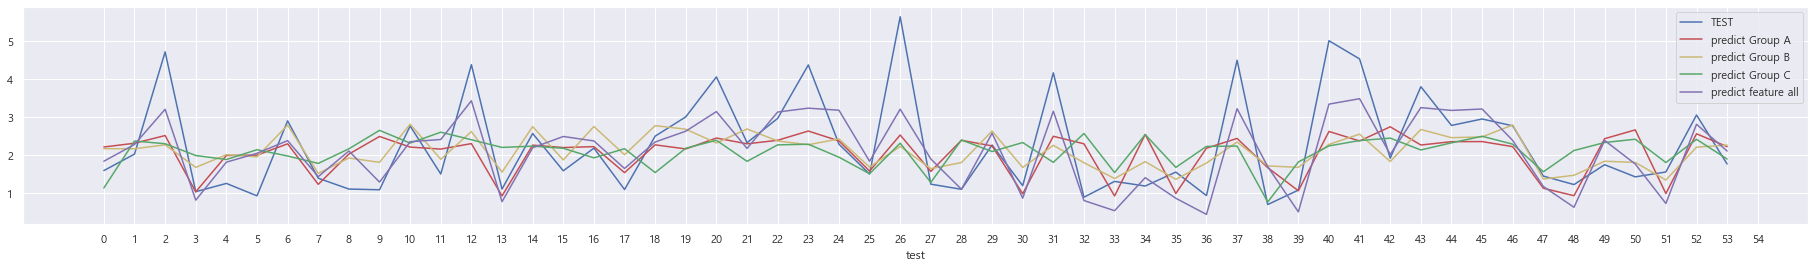

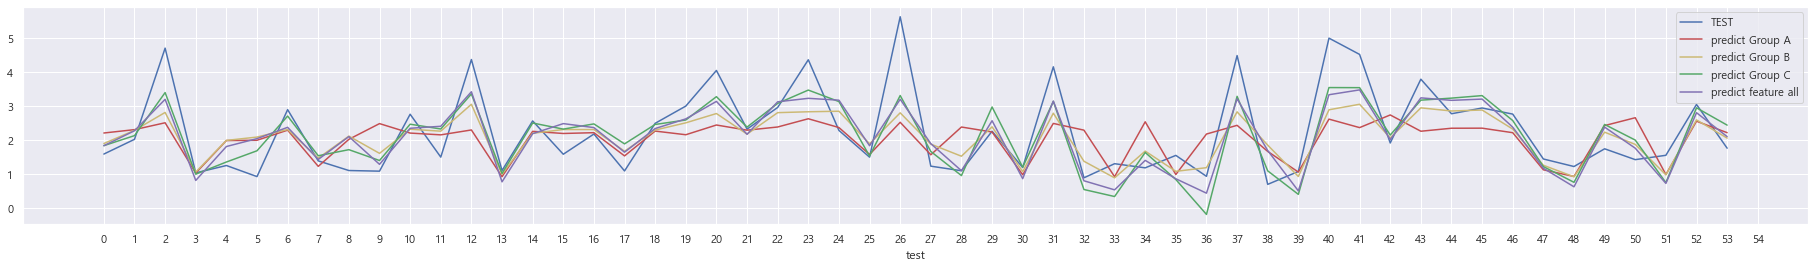

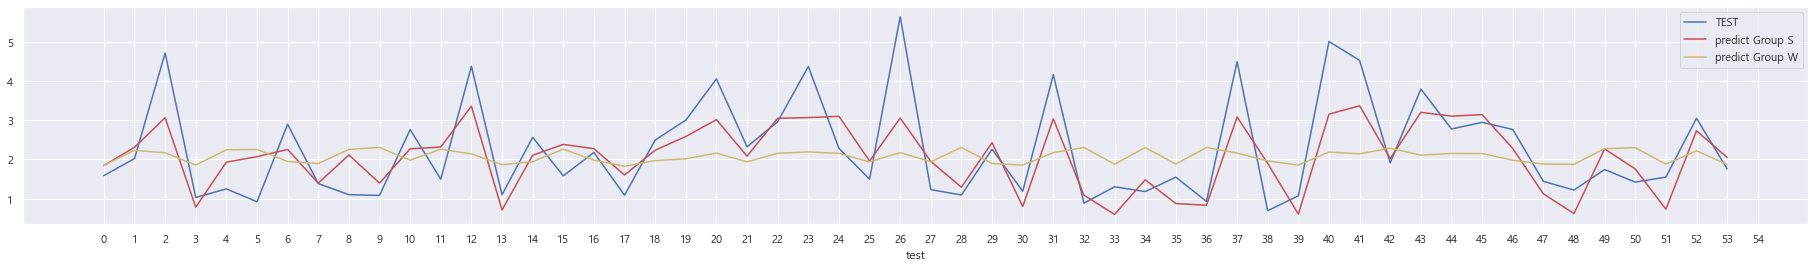

In [39]:
# 단일변수 한번에 시각화
fig, axs = plt.subplots(1,1, figsize=(32,4))
plt.xlabel("test")
plt.xticks(range(55), range(55))
plt.plot(yd_test, label="TEST")
plt.plot(xa_pred, label="predict Group A", c='r')
plt.plot(xb_pred, label="predict Group B", c='y')
plt.plot(xc_pred, label="predict Group C", c='g')
plt.plot(xd_pred, label="predict feature all", c='m')

plt.legend(loc='upper right')
plt.show()

# 합친변수 한번에 시각화
fig, axs = plt.subplots(1,1, figsize=(32,4))
plt.xlabel("test")
plt.xticks(range(55), range(55))
plt.plot(ydd_test, label="TEST")
plt.plot(xaa_pred, label="predict Group A", c='r')
plt.plot(xbb_pred, label="predict Group B", c='y')
plt.plot(xcc_pred, label="predict Group C", c='g')
plt.plot(xdd_pred, label="predict feature all", c='m')

plt.legend(loc='upper right')
plt.show()

## 강한, 약한 변수
fig, axs = plt.subplots(1,1, figsize=(32,4))
plt.xlabel("test")
plt.xticks(range(55), range(55))
plt.plot(ydd_test, label="TEST")
plt.plot(xas_pred, label="predict Group S", c='r')
plt.plot(xbw_pred, label="predict Group W", c='y')


plt.legend(loc='upper right')
plt.show()

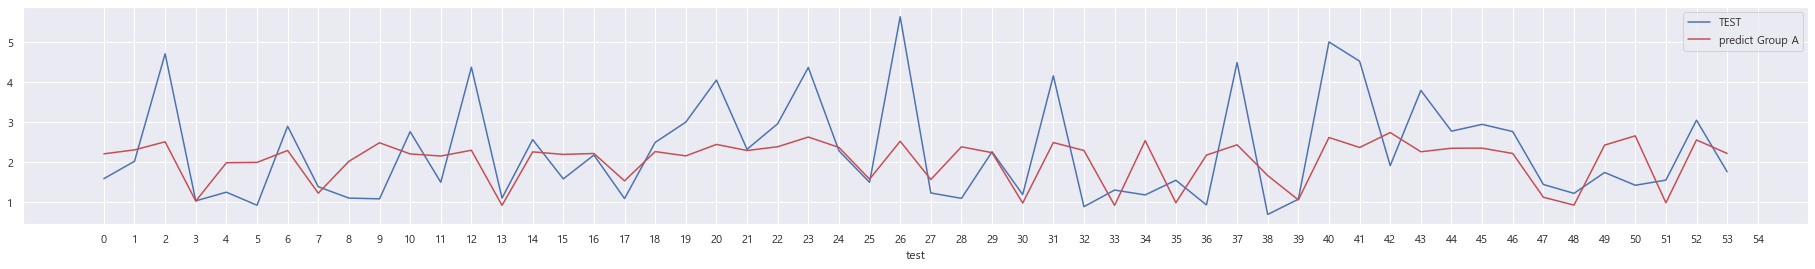

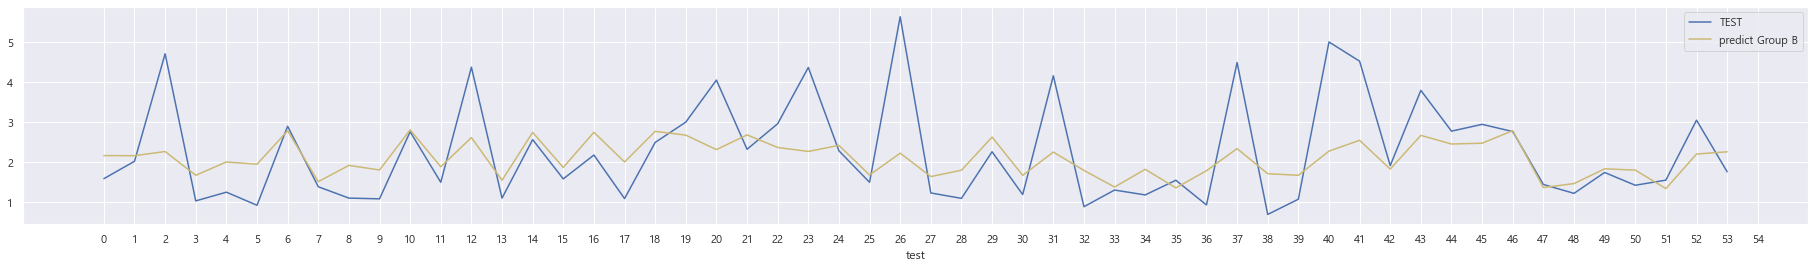

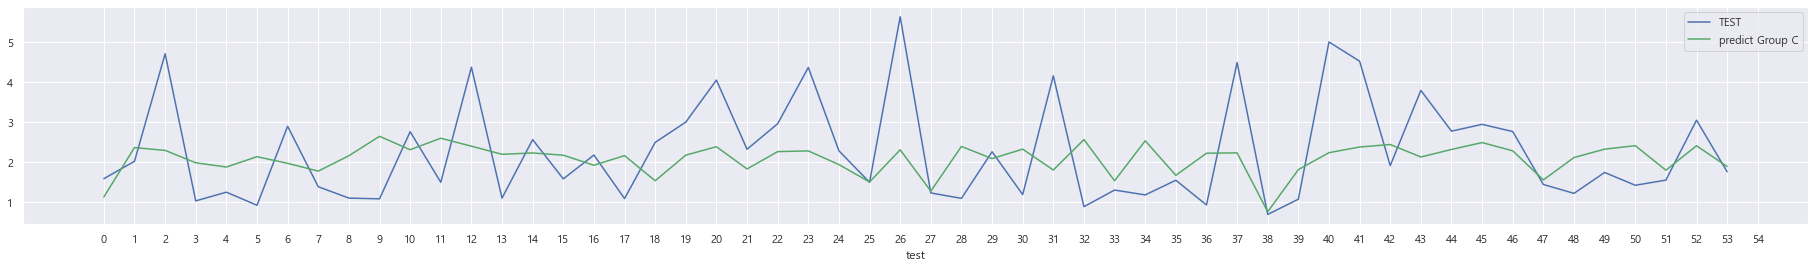

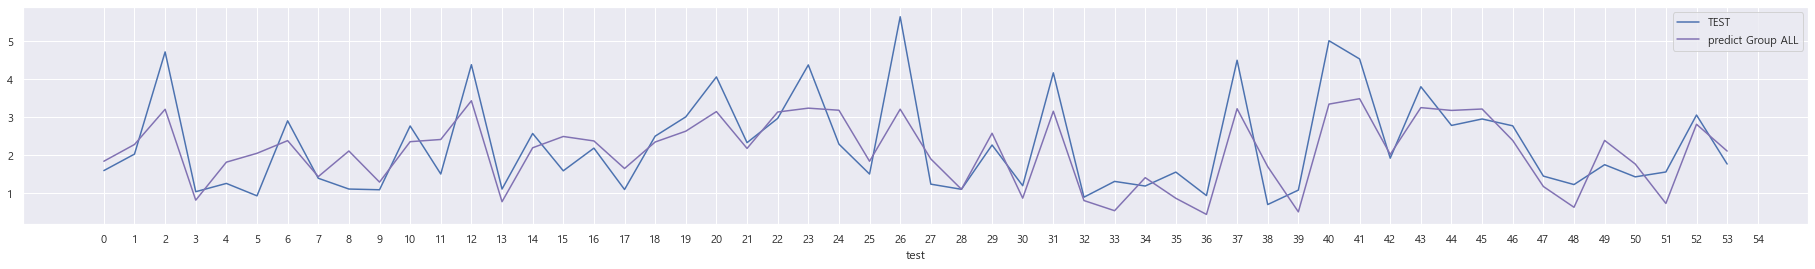

In [25]:
# 단일변수 각각 시각화
fig, axs = plt.subplots(1,1, figsize=(32,4))
plt.xlabel("test")
plt.xticks(range(55), range(55))
plt.plot(ya_test, label="TEST")
plt.plot(xa_pred, label="predict Group A", c='r')
plt.legend(loc='upper right')
plt.show()

fig, axs = plt.subplots(1,1, figsize=(32,4))
plt.xlabel("test")
plt.xticks(range(55), range(55))
plt.plot(yb_test, label="TEST")
plt.plot(xb_pred, label="predict Group B", c='y')
plt.legend(loc='upper right')
plt.show()

fig, axs = plt.subplots(1,1, figsize=(32,4))
plt.xlabel("test")
plt.xticks(range(55), range(55))
plt.plot(yc_test, label="TEST")
plt.plot(xc_pred, label="predict Group C", c='g')
plt.legend(loc='upper right')
plt.show()

fig, axs = plt.subplots(1,1, figsize=(32,4))
plt.xlabel("test")
plt.xticks(range(55), range(55))
plt.plot(yd_test, label="TEST")
plt.plot(xd_pred, label="predict Group ALL", c='m')
plt.legend(loc='upper right')
plt.show()

In [31]:
# 그래서 RMSE가 얼마나 나왔을까

from sklearn.metrics import mean_squared_error, accuracy_score

mse_a = mean_squared_error(ya_test, xa_pred)
rmse_a = mse_a ** 0.5

mse_b = mean_squared_error(yb_test, xb_pred)
rmse_b = mse_b ** 0.5

mse_c = mean_squared_error(yc_test, xc_pred)
rmse_c = mse_c ** 0.5

mse_all = mean_squared_error(yd_test, xd_pred)
rmse_all = mse_all ** 0.5

print(f'금리 요인 RMSE : {rmse_a:.3f}')
print(f'부동산 요인 RMSE : {rmse_b:.3f}')
print(f'거시경제 요인 RMSE : {rmse_c:.3f}')
print(f'전체 요인 RMSE : {rmse_all:.3f}')

금리 요인 RMSE : 1.100
부동산 요인 RMSE : 1.064
거시경제 요인 RMSE : 1.230
전체 요인 RMSE : 0.748


In [41]:
mse_aa = mean_squared_error(yaa_test, xaa_pred)
rmse_aa = mse_aa ** 0.5

mse_bb = mean_squared_error(ybb_test, xbb_pred)
rmse_bb = mse_bb ** 0.5

mse_cc = mean_squared_error(ycc_test, xcc_pred)
rmse_cc = mse_cc ** 0.5

mse_all2 = mean_squared_error(ydd_test, xdd_pred)
rmse_all2 = mse_all2 ** 0.5

print(f'금리 요인 RMSE : {rmse_aa:.3f}')
print(f'금리+부동산 요인 RMSE : {rmse_bb:.3f}')
print(f'금리+부동산+거시경제 요인 RMSE : {rmse_cc:.3f}')
print(f'전체 요인 RMSE : {rmse_all2:.3f}')

금리 요인 RMSE : 1.100
금리+부동산 요인 RMSE : 0.861
금리+부동산+거시경제 요인 RMSE : 0.704
전체 요인 RMSE : 0.748


----------------------------------------------------------------------------
----------------------------------------------------------------------------
##### 생각해볼 것
> 1. 상대적으로 RMSE가 좋지 않다고 판된되는 그룹들을 대상으로 앙상블 수행  
> 2. 금리 요인을 시작으로 하나하나 추가하면서 다시 분석해보기 (+ 다른 feature 찾기)  
> 3. 만기 전 상환율을 ARIMA로 예측이 가능한... 거 맞아?  


- 위에 있는 건 아까 best alpha 구했을 때하고 비교하면 좋을 거 같고

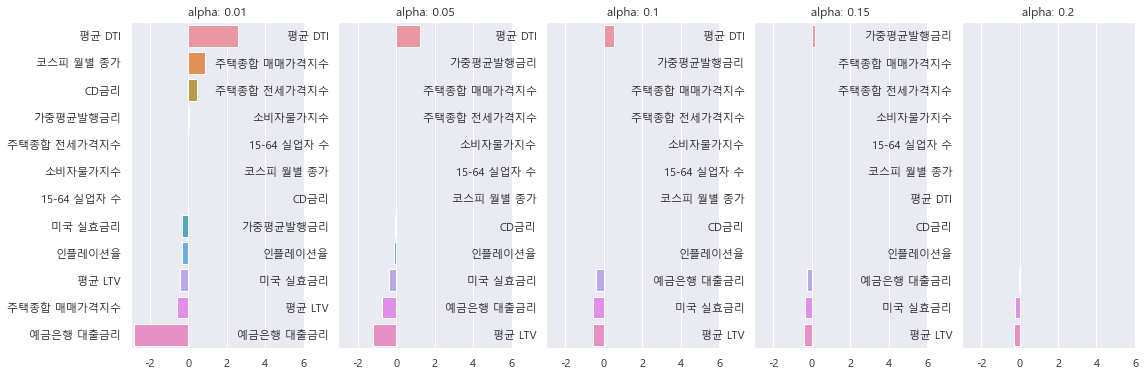

             alpha: 0.01  alpha: 0.05  alpha: 0.1  alpha: 0.15  alpha: 0.2
평균 DTI          2.574141     1.218307    0.531442     0.195661    0.000000
코스피 월별 종가       0.848891     0.000000    0.000000     0.000000    0.000000
CD금리            0.463073     0.000000   -0.000000    -0.000000   -0.000000
가중평균발행금리        0.028216    -0.047976   -0.000000    -0.000000   -0.000000
주택종합 전세가격지수     0.000000     0.000000    0.000000     0.000000    0.000000
소비자물가지수        -0.000000     0.000000    0.000000     0.000000    0.000000
15-64 실업자 수    -0.000000     0.000000    0.000000     0.000000    0.000000
미국 실효금리        -0.317467    -0.349849   -0.389577    -0.327146   -0.245366
인플레이션율         -0.334132    -0.125762   -0.000000    -0.000000   -0.000000
평균 LTV         -0.442539    -0.727672   -0.573189    -0.422991   -0.292807
주택종합 매매가격지수    -0.581067    -0.000000   -0.000000     0.000000    0.000000
예금은행 대출금리      -2.839756    -1.179818   -0.558286    -0.230504   -0.032564


In [32]:
# 문득 이런 생각
# Best alpha로 RMSE를 찾긴 찾았는데
# 그래프 뭐가 대충 일치하는 게 보였어. 근데 전체 요인이 Best야
# 알파를 좀 더 변화시켜보자. 뭐가 큰 영향을 준 걸까.
# 이거도 요인 별로 하나하나 돌려봅시다

from test_package import check_coeff

# 구하고 싶은 알파는 따로 입력하고
alphas = [0.01, 0.05, 0.1, 0.15, 0.2]

# check_coeff(type, data, target, alpha)
# type = 'ridge', 'lasso', 'elastic'
check_coeff('elastic', feature_data, target, alphas)

In [ ]:
# 구하고 싶은 알파는 따로 입력
alphas = [0.01, 0.05, 0.1, 0.15, 0.2]

# check_coeff(type, data, target, alpha)
# type = 'ridge', 'lasso', 'elastic'
check_coeff('elastic', feature_data_A, target, alphas)

# 구하고 싶은 알파는 따로 입력하고
alphas = [0.01, 0.05, 0.1, 0.15, 0.2]

# check_coeff(type, data, target, alpha)
# type = 'ridge', 'lasso', 'elastic'
check_coeff('elastic', feature_data_B, target, alphas)

# 구하고 싶은 알파는 따로 입력하고
alphas = [0.01, 0.05, 0.1, 0.15, 0.2]

# check_coeff(type, data, target, alpha)
# type = 'ridge', 'lasso', 'elastic'
check_coeff('elastic', feature_data_C, target, alphas)

In [ ]:
feature_data_best = feature_data[['평균 LTV', '평균 DTI', '예금은행 대출금리', '미국 실효금리']]
feature_data_best

In [ ]:
from test_package import score_checker


find_best_alpha('elastic', feature_data_best[:161], target[:161])
score_checker('elastic', feature_data_best[:161], target[:161], 0.01)

In [ ]:
# Best Feature Training
xe_train, xe_test, ye_train, ye_test = train_test_split(feature_data_best, target, test_size=0.25, random_state=25)
xe_model = ElasticNet(alpha=0.01, random_state=25)
xe_model.fit(xe_train, ye_train)
xe_pred = xe_model.predict(xe_test)

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(32,8))
plt.xlabel("test")
plt.xticks(range(55), range(55))
plt.plot(ye_test, label="TEST")
plt.plot(xe_pred, label="predict Group Best")
plt.legend(loc='upper right')
plt.show()

In [ ]:
alphas = [0.2, 0.225, 0.25, 0.275, 0.3]
check_coeff('elastic', feature_data_best, target, alphas)

In [ ]:
feature_data_others = feature_data[['가중평균발행금리', '주택종합 매매가격지수', '소비자물가지수', '15-64 실업자 수', '코스피 월별 종가', '인플레이션율']]
feature_data_others

In [ ]:
find_best_alpha('elastic', feature_data_others[:161], target[:161])
score_checker('elastic', feature_data_others[:161], target[:161], 0.01)

In [ ]:
# Other Feature Training
xf_train, xf_test, yf_train, yf_test = train_test_split(feature_data_others, target, test_size=0.25, random_state=25)
xf_model = ElasticNet(alpha=0.01, random_state=25)
xf_model.fit(xf_train, yf_train)
xf_pred = xf_model.predict(xf_test)

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(32,8))
plt.xlabel("test")
plt.xticks(range(55), range(55))
plt.plot(yf_test, label="TEST")
plt.plot(xf_pred, label="predict Group Others")
plt.legend(loc='upper right')
plt.show()

In [ ]:
alphas = [0.01, 0.05, 0.1, 0.15, 0.175]
check_coeff('elastic', feature_data_others, target, alphas)

In [ ]:
feature_data_real_best = feature_data[['평균 LTV', '평균 DTI', '예금은행 대출금리', '미국 실효금리', '소비자물가지수', '가중평균발행금리']]
feature_data_real_best

In [ ]:
find_best_alpha('elastic', feature_data_real_best[:161], target[:161])
score_checker('elastic', feature_data_real_best[:161], target[:161], 0.01)

In [ ]:
# real best Feature Training
xg_train, xg_test, yg_train, yg_test = train_test_split(feature_data_real_best, target, test_size=0.25, random_state=25)
xg_model = ElasticNet(alpha=0.01, random_state=25)
xg_model.fit(xg_train, yg_train)
xg_pred = xg_model.predict(xg_test)

xs = data_a.index.to_list()


fig, axs = plt.subplots(1,1, figsize=(32,8))
plt.xlabel("test")
plt.xticks(range(55), range(55))
plt.plot(yg_test, label="TEST")
plt.plot(xg_pred, label="predict Group Others")
plt.legend(loc='upper right')
plt.show()

In [ ]:
alphas = [0.01, 0.05, 0.1, 0.15, 0.2]
check_coeff('elastic', feature_data_real_best, target, alphas)

In [42]:
#### 그래프 시각화 잘하기